In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import pandas as pd
import sys

sys.path.append("../")

In [ ]:
from src.epl_player_data_utils import EPLPlayerData

epl_player_data = EPLPlayerData("../SampleData/players.json")
epl_player_data

In [ ]:
shots_dataset = pd.read_csv("shots_dataset.csv").drop(columns=["lineup_id"])
shots_dataset

In [6]:
# Scale shots_ratio using LogNormal

from sklearn.preprocessing import PowerTransformer, StandardScaler, MinMaxScaler

# power_transformer = StandardScaler()s
# shots_dataset["shots_ratio"] = power_transformer.fit_transform(shots_dataset[["shots_ratio"]])

In [ ]:
players = shots_dataset["player_id"].unique().astype(int)
player_pos = {player: epl_player_data.get_player_position(player) for player in players}

shots_dataset["player_position"] = shots_dataset["player_id"].apply(lambda x: player_pos[x])
shots_dataset

In [ ]:
shots_dataset_non_zero = shots_dataset[shots_dataset["shots_ratio"] > 0]
shots_dataset_non_zero

In [ ]:
shots_dataset_non_zero["player_position"].value_counts().plot(kind="bar")

In [ ]:
shots_dataset_enc = pd.get_dummies(shots_dataset_non_zero, columns=["player_position"])
shots_dataset_enc

In [ ]:
# Last 111 Match IDs are test set
train_set = shots_dataset_enc[shots_dataset_enc["match_num"] <= 379 - 111]
test_set = shots_dataset_enc[shots_dataset_enc["match_num"] > 379 - 111]

train_set["match_num"].unique().shape, test_set["match_num"].unique().shape

In [12]:
import xgboost as xgb
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from matplotlib import pyplot as plt
import numpy as np

In [ ]:
def fit_xgb_model(train_set, target_column, drop_columns):
    model = xgb.XGBRegressor(objective="reg:squarederror")
    model.fit(train_set.drop(columns=drop_columns), train_set[target_column])
    return model


def predict_and_evaluate(model, data_set, target_column, drop_columns):
    preds = model.predict(data_set.drop(columns=drop_columns))
    mse = mean_squared_error(data_set[target_column], preds)
    pearson = np.corrcoef(data_set[target_column], preds)[0, 1]
    return preds, mse, pearson


def plot_scatter_with_regression(ax, x, y, title):
    ax.scatter(x, y)
    ax.set_title(title)
    # Plot y=x line
    ax.plot([0, 1], [0, 1],
        transform=ax.transAxes, 
        linestyle="--", color="black"
    )
    # Plot regression line using linear regression
    lr_model = LinearRegression()
    lr_model.fit(x.values.reshape(-1, 1), y)
    x_line = np.linspace(0, 1, 100)
    slope = lr_model.coef_[0]
    intercept = lr_model.intercept_
    ax.plot(
        x_line,
        lr_model.predict(x_line.reshape(-1, 1)),
        color="red",
        label=f"y={slope:.2f}x + {intercept:.2f}",
    )
    ax.legend()


# Datos de entrada
target_column = "shots_ratio"
drop_columns = ["shots_ratio", "match_id", "player_id", "match_num"]

# Ajustar el modelo XGBoost
xgb_model = fit_xgb_model(train_set, target_column, drop_columns)

# Predecir y evaluar el modelo
train_preds, train_mse, train_pearson = predict_and_evaluate(
    xgb_model, train_set, target_column, drop_columns
)
test_preds, test_mse, test_pearson = predict_and_evaluate(
    xgb_model, test_set, target_column, drop_columns
)

# Mostrar MSE
print(f"Train MSE: {train_mse}, Test MSE: {test_mse}")

# Graficar los resultados
fig, ax = plt.subplots(1, 2, figsize=(20, 10))

plot_scatter_with_regression(ax[0], train_set[target_column], train_preds, f"Train Set - Pearson: {train_pearson:.2f} - MSE: {train_mse:.2f}")
plot_scatter_with_regression(ax[1], test_set[target_column], test_preds, f"Test Set - Pearson: {test_pearson:.2f} - MSE: {test_mse:.2f}")

plt.show()

In [ ]:
lr_model = LinearRegression()
lr_model.fit(train_set.drop(columns=drop_columns), train_set[target_column])

train_preds, train_mse = predict_and_evaluate(
    lr_model, train_set, target_column, drop_columns
)
test_preds, test_mse = predict_and_evaluate(
    lr_model, test_set, target_column, drop_columns
)

print(f"Train MSE: {train_mse}, Test MSE: {test_mse}")

fig, ax = plt.subplots(1, 2, figsize=(20, 10))

plot_scatter_with_regression(ax[0], train_set[target_column], train_preds, "Train Set")
plot_scatter_with_regression(ax[1], test_set[target_column], test_preds, "Test Set")

plt.show()

In [ ]:
# Feature importance
fig, ax = plt.subplots(1, 2, figsize=(20, 10))

xgb_importance = xgb_model.feature_importances_
xgb_importance /= xgb_importance.sum()
ax[0].barh(train_set.drop(columns=drop_columns).columns, xgb_importance)
ax[0].set_title("XGBoost Model")

lr_importance = np.abs(lr_model.coef_)
lr_importance /= lr_importance.sum()
ax[1].barh(train_set.drop(columns=drop_columns).columns, lr_importance)
ax[1].set_title("Linear Regression Model")

In [14]:
def load_player_features_dataframe(filepath):
    # Load the DataFrame from disk
    return pd.read_parquet(filepath)


def get_features_from_df(player_id, match_id, features_df, cols):
    return features_df.loc[(player_id, match_id)][cols].to_dict()
    # try:
    # except KeyError:
    #     return {col: 0 for col in cols}


player_features_df = load_player_features_dataframe("player_features_optimized.parquet")

In [ ]:
list(player_features_df.iloc[0].index)

In [119]:
# # DataLeakage Features

# player_features = {}

# # For each player in player_features_df, get last match by date in which player played
# # and get the features for that match divided the total minutes played by the player ("minutes")

# for player_id in player_features_df.index.get_level_values(0).unique():

#     last = player_features_df.loc[player_id].sort_values("match_date").iloc[-1]
#     # Drop match_date
#     # last = last.drop("match_date")
#     if last["minutes"] != 0:
#         for col in last.index:
#             if col != "match_date":
#                 last[col] = last[col] / last["minutes"]

#     player_features[player_id] = last.to_dict()

# ds_w_features = shots_dataset_enc.copy()

# # Add player features to dataset
# for col in player_features_df.columns:
#     ds_w_features[col] = ds_w_features.apply(
#         lambda x: player_features.get(x["player_id"]).get(col), axis=1
#     )

# ds_w_features

In [ ]:
# # Copiar el DataFrame original
ds_w_features = shots_dataset_enc.copy()

# Aplicar la función y expandir el diccionario en nuevas columnas
feature_cols = []

for row in ds_w_features.itertuples():
    player_id = row.player_id
    match_id = row.match_id
    features = get_features_from_df(
        player_id,
        match_id,
        player_features_df,
        ["pases/90", "shots/90", "losses/90", "gains/90", "minutes", "match_date"],
    )
    for col, value in features.items():
        ds_w_features.at[row.Index, col] = value

# Verificar el resultado
ds_w_features.head()

In [16]:
# Model with player features

# Last 111 Match IDs are test set
f_train_set = ds_w_features[
    (ds_w_features["match_num"] <= 379 - 111) & (ds_w_features["match_num"] > 100)
]
f_test_set = ds_w_features[
    ds_w_features["match_num"] > 379 - 111
]

In [ ]:
f_train_set

In [ ]:
# Feature Engineering

# Multiply  pases/90	shots/90	losses/90	gains/90 by minutes
f_train_set["pases"] = f_train_set["pases/90"] * f_train_set["minutes"]
f_train_set["shots"] = f_train_set["shots/90"] * f_train_set["minutes"]
f_train_set["losses"] = f_train_set["losses/90"] * f_train_set["minutes"]
f_train_set["gains"] = f_train_set["gains/90"] * f_train_set["minutes"]

f_test_set["pases"] = f_test_set["pases/90"] * f_test_set["minutes"]
f_test_set["shots"] = f_test_set["shots/90"] * f_test_set["minutes"]
f_test_set["losses"] = f_test_set["losses/90"] * f_test_set["minutes"]
f_test_set["gains"] = f_test_set["gains/90"] * f_test_set["minutes"]


In [ ]:
# Datos de entrada
target_column = "shots_ratio"
drop_columns = ["shots_ratio", "match_id", "player_id", "match_date", "match_num"]

# Ajustar el modelo XGBoost
xgb_model = fit_xgb_model(f_train_set, target_column, drop_columns)

# Predecir y evaluar el modelo
train_preds, train_mse, train_pearson = predict_and_evaluate(
    xgb_model, f_train_set, target_column, drop_columns
)
test_preds, test_mse, test_pearson = predict_and_evaluate(
    xgb_model, f_test_set, target_column, drop_columns
)

# Mostrar MSE
print(f"Train MSE: {train_mse}, Test MSE: {test_mse}")

# Graficar los resultados
fig, ax = plt.subplots(1, 2, figsize=(20, 10))

plot_scatter_with_regression(ax[0], f_train_set[target_column], train_preds, f"Train Set - Pearson: {train_pearson:.2f} - MSE: {train_mse:.2f}")
plot_scatter_with_regression(ax[1], f_test_set[target_column], test_preds, f"Test Set - Pearson: {test_pearson:.2f} - MSE: {test_mse:.2f}")

plt.show()


Train MSE: 0.0004845216931486636, Test MSE: 0.0029676321509039816


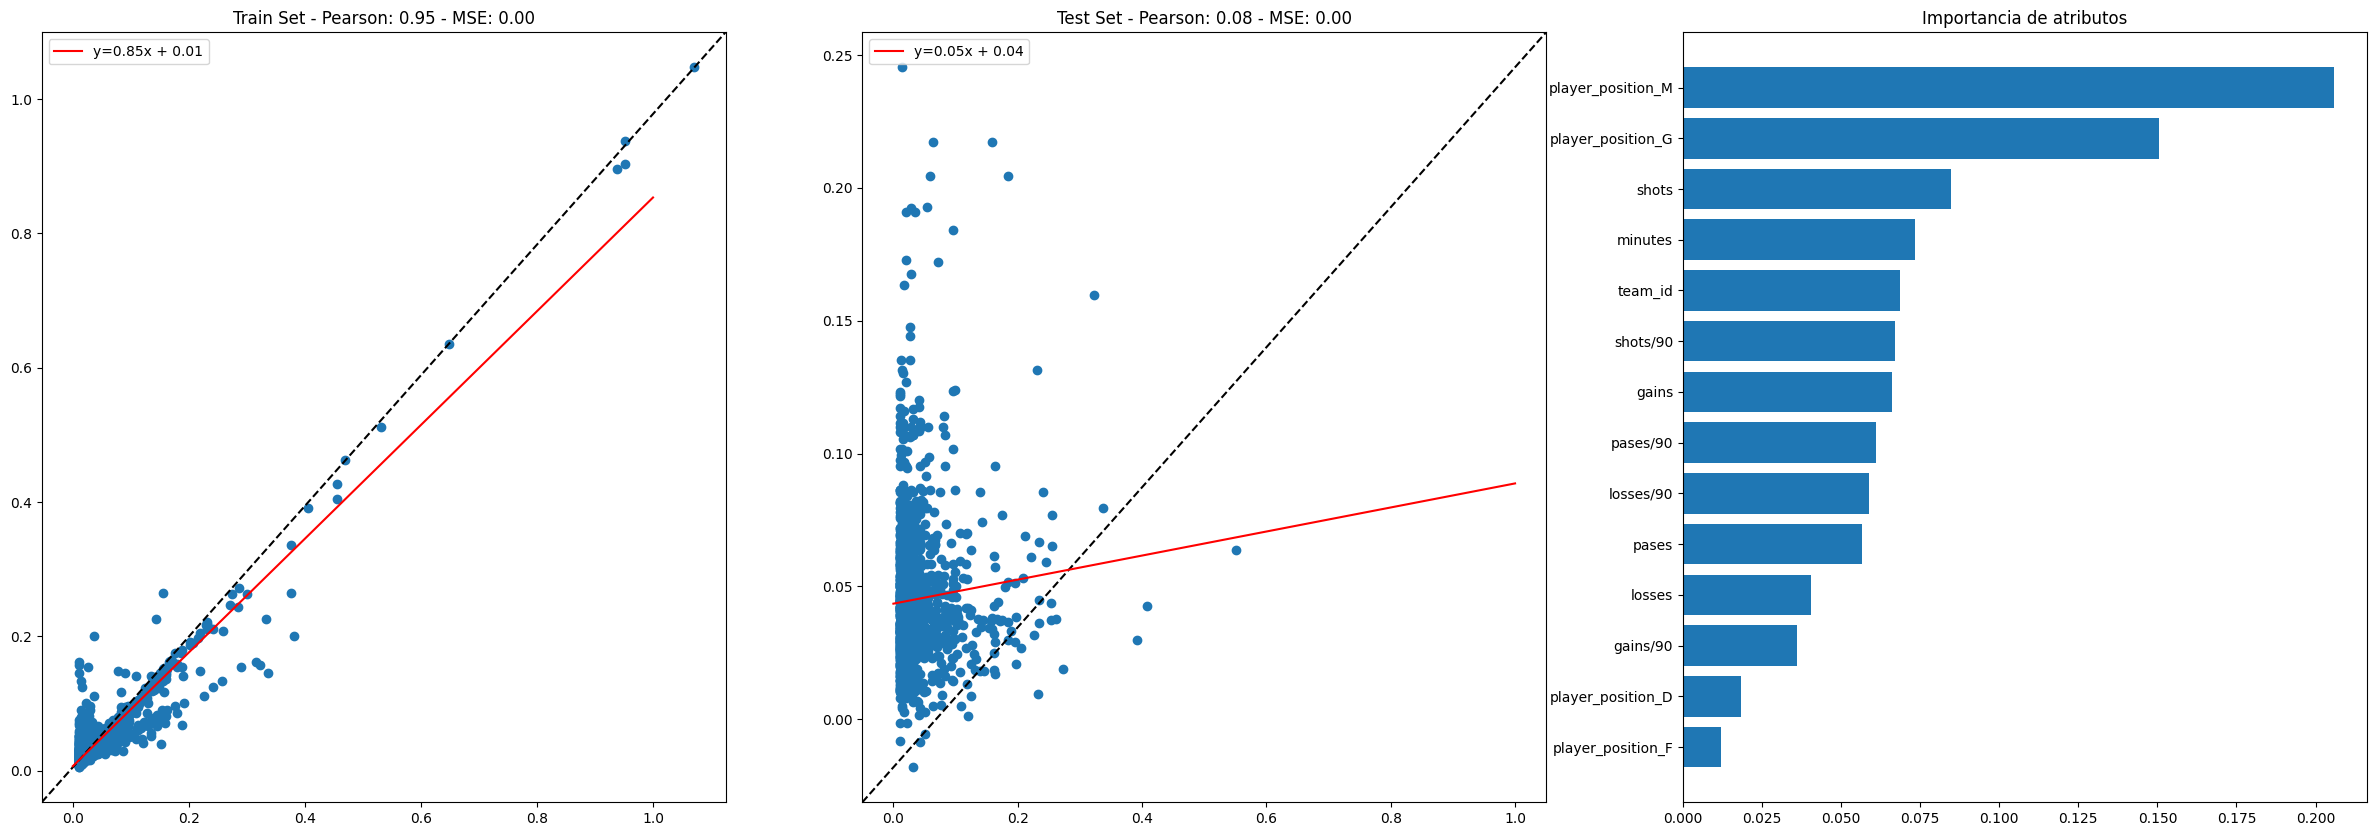

In [40]:
# Datos de entrada
target_column = "shots_ratio"
drop_columns = ["shots_ratio", "match_id", "player_id", "match_date", "match_num"]

# Ajustar el modelo XGBoost
xgb_model = fit_xgb_model(f_train_set, target_column, drop_columns)

# Predecir y evaluar el modelo
train_preds, train_mse, train_pearson = predict_and_evaluate(
    xgb_model, f_train_set, target_column, drop_columns
)
test_preds, test_mse, test_pearson = predict_and_evaluate(
    xgb_model, f_test_set, target_column, drop_columns
)

# Mostrar MSE
print(f"Train MSE: {train_mse}, Test MSE: {test_mse}")

# Graficar los resultados
fig, ax = plt.subplots(1, 3, figsize=(30, 10))

plot_scatter_with_regression(
    ax[0],
    f_train_set[target_column],
    train_preds,
    f"Train Set - Pearson: {train_pearson:.2f} - MSE: {train_mse:.2f}",
)
plot_scatter_with_regression(
    ax[1],
    f_test_set[target_column],
    test_preds,
    f"Test Set - Pearson: {test_pearson:.2f} - MSE: {test_mse:.2f}",
)

# Feature importance
xgb_importance = xgb_model.feature_importances_
xgb_importance /= xgb_importance.sum()

# Sorted
sorted_idx = np.argsort(xgb_importance)

ax[2].barh(
    f_train_set.drop(columns=drop_columns).columns[sorted_idx],
    xgb_importance[sorted_idx],
)
ax[2].set_title("Importancia de atributos")

plt.show()

/Users/nacho/Desktop/code/understat-xg/.conda/lib/python3.10/site-packages/numpy/lib/function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/Users/nacho/Desktop/code/understat-xg/.conda/lib/python3.10/site-packages/numpy/lib/function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
/Users/nacho/Desktop/code/understat-xg/.conda/lib/python3.10/site-packages/numpy/lib/function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/Users/nacho/Desktop/code/understat-xg/.conda/lib/python3.10/site-packages/numpy/lib/function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
/var/folders/5j/7b3w3dw95qdcll87vxc3yn300000gn/T/ipykernel_66361/2896859881.py:82: RuntimeWarning: invalid value encountered in divide
  xgb_importance /= xgb_importance.sum()


Train MSE: 0.004657590386703487, Test MSE: 0.0023353654903810303


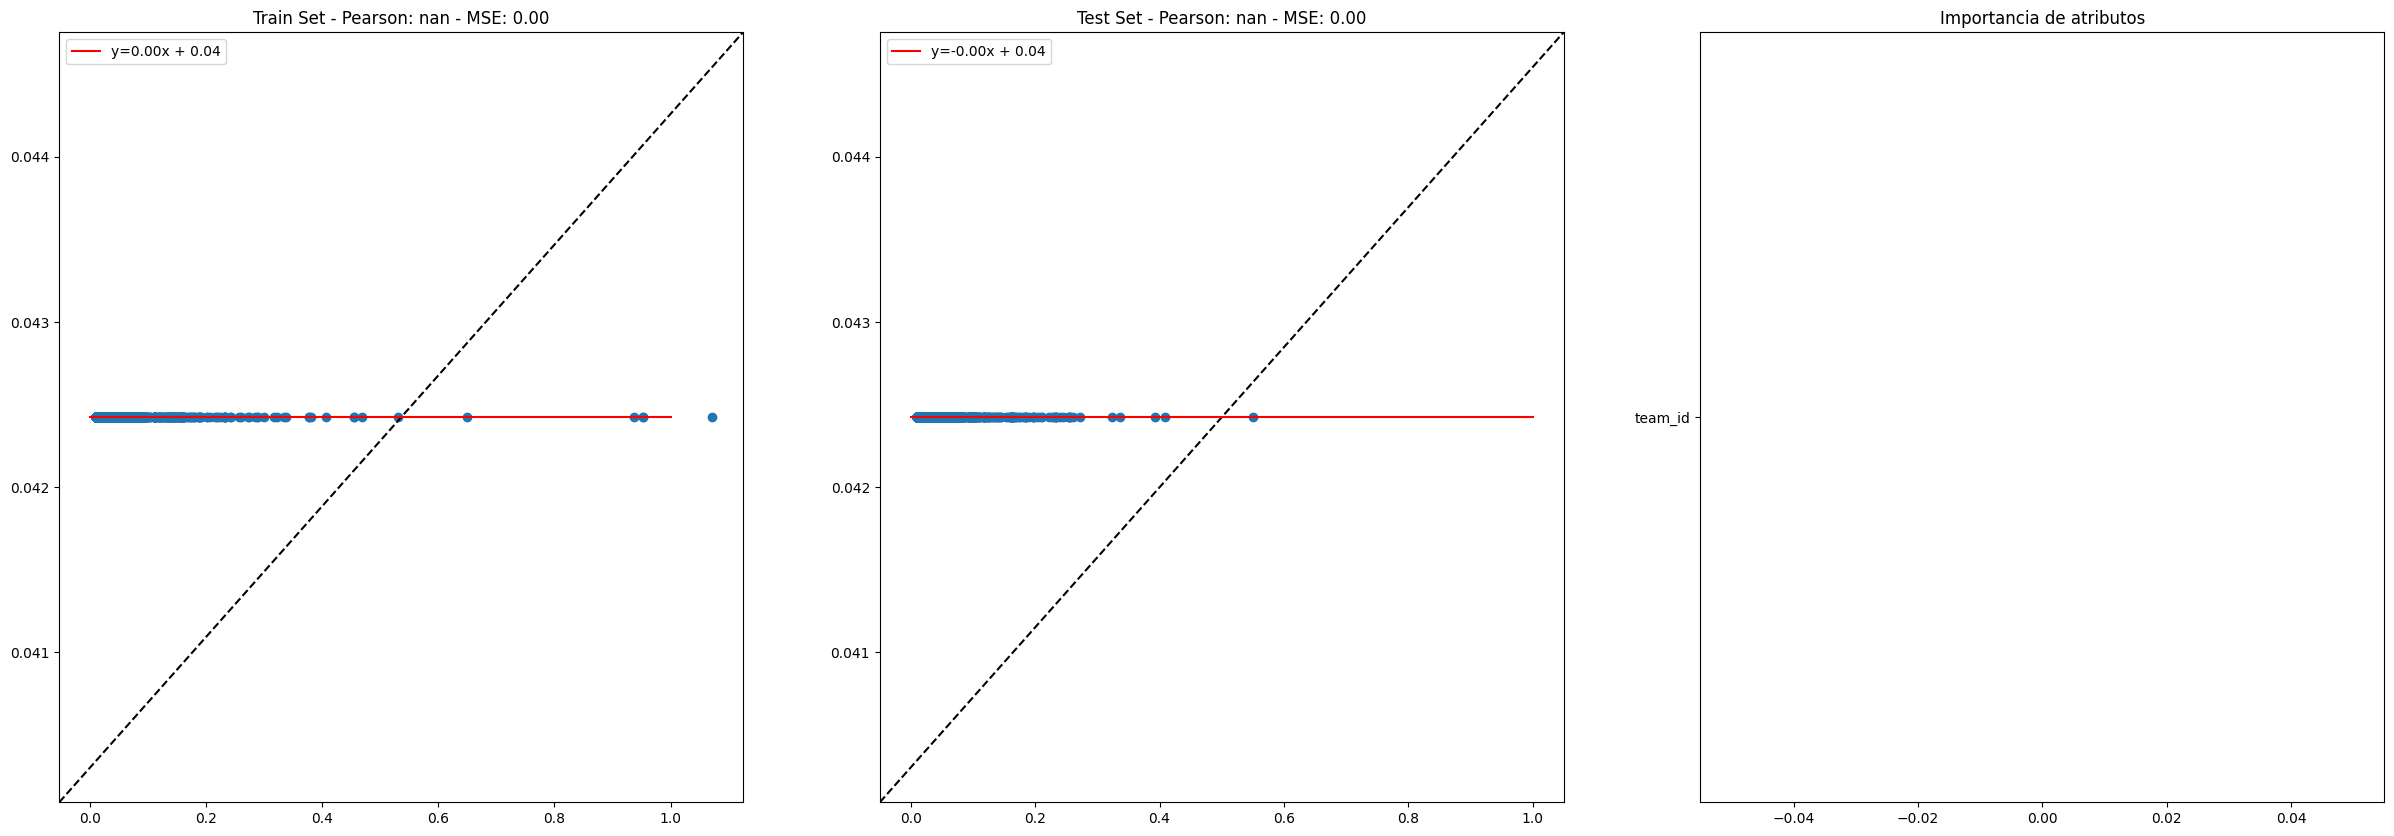

In [53]:
from sklearn.model_selection import GridSearchCV, PredefinedSplit, RandomizedSearchCV


def fit_and_tune_xgb_model(train_set, target_column, drop_columns):
    model = xgb.XGBRegressor(objective="reg:squarederror")

    # Grid Search
    param_grid = {
        "n_estimators": [10, 50, 100, 200, 300],
        "max_depth": [3, 5, 7, 20, 50],
        "learning_rate": [0.5, 0.1, 0.01, 0.001],
        "subsample": [0.5, 0.7, 0.9, 1],
        "colsample_bytree": [0.5, 0.7, 0.9, 1],
        "gamma": [0, 0.1, 0.2, 0.3, 0.4],
        "reg_alpha": [0, 0.1, 0.5, 1],
        "reg_lambda": [0, 0.1, 0.5, 1],
    }

    # Split the dataset into training and validation sets
    val_set = train_set[train_set["match_num"] > 379 - (111 + 100)]
    train_set = train_set[train_set["match_num"] <= 379 - (111 + 100)]

    # Combine train_set and val_set for PredefinedSplit
    combined_set = pd.concat([train_set, val_set])
    test_fold = [-1] * train_set.shape[0] + [0] * val_set.shape[0]
    ps = PredefinedSplit(test_fold=test_fold)

    param_search = RandomizedSearchCV(
        model,
        param_grid,
        cv=ps,
        scoring="neg_mean_squared_error",
        n_jobs=-1,
        n_iter=100,
    )

    # Fit the model using the combined set
    param_search.fit(
        combined_set.drop(columns=drop_columns), combined_set[target_column]
    )

    return param_search.best_estimator_


# Datos de entrada
target_column = "shots_ratio"
drop_columns = ["shots_ratio", "match_id", "player_id", "match_date", "match_num"]

# Ajustar el modelo XGBoost
# xgb_model = fit_xgb_model(f_train_set, target_column, drop_columns)
xgb_model = fit_and_tune_xgb_model(f_train_set, target_column, drop_columns)

# Predecir y evaluar el modelo
train_preds, train_mse, train_pearson = predict_and_evaluate(
    xgb_model, f_train_set, target_column, drop_columns
)
test_preds, test_mse, test_pearson = predict_and_evaluate(
    xgb_model, f_test_set, target_column, drop_columns
)

# Mostrar MSE
print(f"Train MSE: {train_mse}, Test MSE: {test_mse}")

# Graficar los resultados
fig, ax = plt.subplots(1, 3, figsize=(30, 10))

plot_scatter_with_regression(
    ax[0],
    f_train_set[target_column],
    train_preds,
    f"Train Set - Pearson: {train_pearson:.2f} - MSE: {train_mse:.2f}",
)
plot_scatter_with_regression(
    ax[1],
    f_test_set[target_column],
    test_preds,
    f"Test Set - Pearson: {test_pearson:.2f} - MSE: {test_mse:.2f}",
)

# Feature importance
xgb_importance = xgb_model.feature_importances_
xgb_importance /= xgb_importance.sum()

# Sorted
sorted_idx = np.argsort(xgb_importance)

ax[2].barh(
    f_train_set.drop(columns=drop_columns).columns[sorted_idx],
    xgb_importance[sorted_idx],
)
ax[2].set_title("Importancia de atributos")

plt.show()

In [ ]:
lr_model = LinearRegression()

lr_model.fit(f_train_set.drop(columns=drop_columns), f_train_set[target_column])

train_preds, train_mse = predict_and_evaluate(
    lr_model, f_train_set, target_column, drop_columns
)
test_preds, test_mse = predict_and_evaluate(
    lr_model, f_test_set, target_column, drop_columns
)

print(f"Train MSE: {train_mse}, Test MSE: {test_mse}")

fig, ax = plt.subplots(1, 2, figsize=(20, 10))

plot_scatter_with_regression(ax[0], f_train_set[target_column], train_preds, "Train Set")
plot_scatter_with_regression(ax[1], f_test_set[target_column], test_preds, "Test Set")

plt.show()

In [ ]:
# Feature importance

fig, ax = plt.subplots(figsize=(20, 10))

xgb_importance = xgb_model.feature_importances_
xgb_importance /= xgb_importance.sum()

importances = pd.Series(xgb_importance, index=f_train_set.drop(columns=drop_columns).columns).sort_values(ascending=True)

ax.barh(importances.index, importances)
